In [1]:
from functions.hawkes_process import *
from functions.GOF import *
from functions.compensator import *
from functions.estimator_class import loglikelihood_estimator_bfgs
from functions.multivariate_exponential_process import *
import scipy
from functions.estimator_class_multi_rep import *


In [2]:
np.random.seed(0)

### Simulation of a Marked Exponential Hawkes Process

We start by simulating a unidimensionnal Hawkes process denoted $N$. The intensity of the process is given by the formula : 
\begin{equation}
   \lambda(t) =   m + \int_{(-\infty ,t)\times \mathcal{E} } a e^{-b(t-s)} \phi_{\gamma, \psi}(\kappa) N(ds \times d\kappa),
\end{equation}

with $\kappa$ beeing i.i.d. random variable with a  c.d.f $F_\psi$,a dmitiing a density $f_\psi$.

In [3]:
m, a, b = 0.8, -1, 2
Tmax = 5
phi_arg = 0.3

## taking kappa i.i.d following a exponential distribution of parameter 1
def F(mark,time,psi):
    return(scipy.stats.expon.cdf(mark, scale = psi))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))

def f(mark,t, psi):
    return(psi*np.exp(-psi*mark))

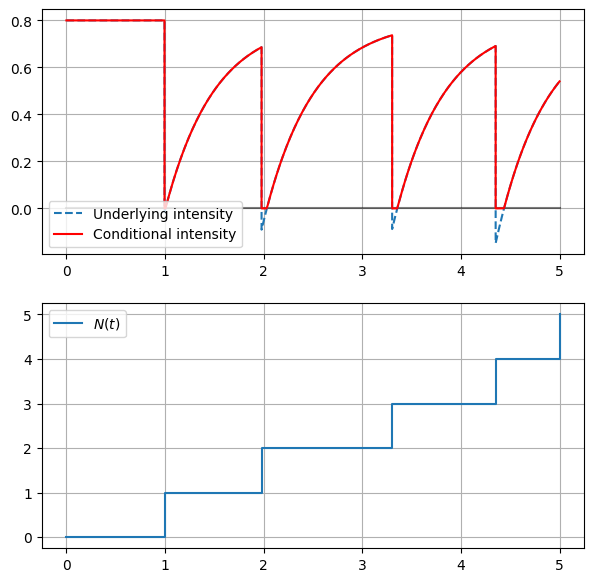

In [4]:
hawkes = exp_thinning_hawkes_marked(m=m,
                                    a=a, 
                                    b=b, 
                                    F = F ,
                                    arg_F = {'psi':1},
                                    phi=phi, 
                                    arg_phi = {'gamma': phi_arg},
                                    max_time = Tmax)


hawkes.simulate()

fig, ax = plt.subplots(2,1, figsize=(7,7))
hawkes.plot_intensity(ax =ax)

We now consider a multidimensionnal Hawkes process for which the intensity $\lambda_i$ of the i-th subprocess takes the form : $\begin{equation}
   \lambda_{i}(t) =   m_i + \sum_{j=1}^{d} \int_{(-\infty ,t)\times \mathcal{E}} a_{ij} e^{-b_i(t-s)} \phi_{\gamma, \psi}(\kappa) N^j(ds \times d\kappa),
\end{equation}$

with $\kappa$ beeing i.i.d. random variable with a  c.d.f $F_\psi$,a dmitiing a density $f_\psi$.

In [5]:
m = np.array([0.5, 0.2]).reshape((2,1))
a = np.array([[0.4, 0.2,], 
                  [-0.4, 0.3]] )
b = np.array([[1],[1.5]])


Tmax = 10
phi_arg = 0.5

def F(mark,time,psi):
    return(scipy.stats.expon.cdf(mark, scale = psi))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))

def f(mark,t, psi):
    return(psi*np.exp(-psi*mark))

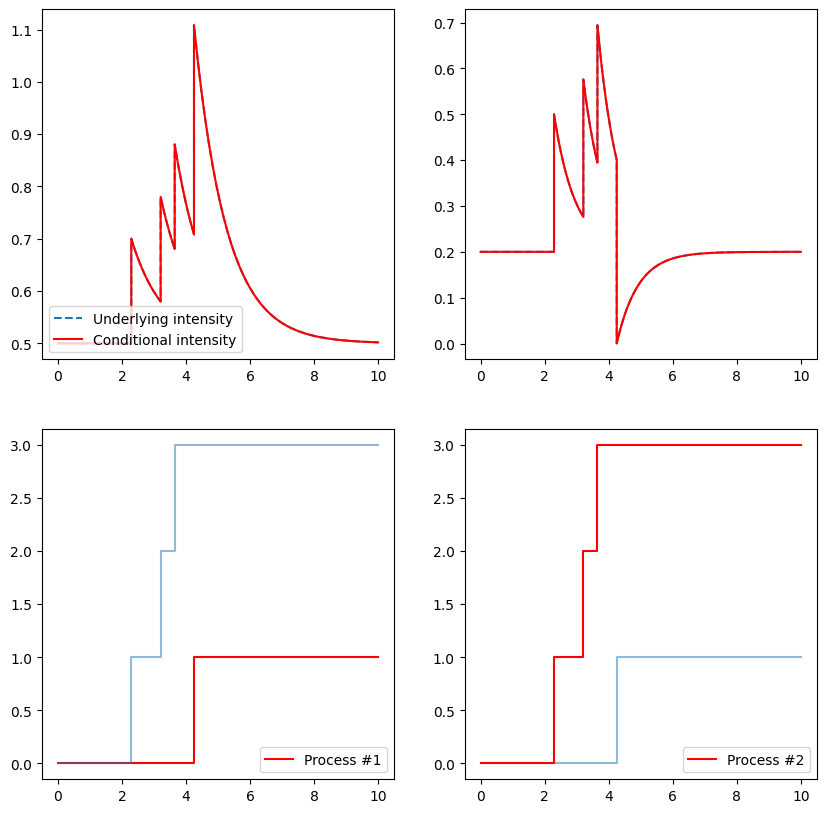

In [6]:
hawkes_multi = multivariate_exponential_hawkes_marked(m=m,
                                                      a=a, 
                                                      b=b, 
                                                      phi = phi, 
                                                      F= F, 
                                                      arg_phi={'gamma':phi_arg}, 
                                                      arg_F={'psi': 2}, 
                                                      max_time=10)

hawkes_multi.simulate()

fig,ax = plt.subplots(2,2, figsize = (10,10))
hawkes_multi.plot_intensity(ax = ax)

# Apply testing procedure

We present here the code use to apply different test procedure on Hawkes process. To that end, we start by simulating a synthetic dataset containing 500 repetitions of a Hawkes process.

In [7]:
## simualtion of the observations

### data generation
m=1
a = -0.6
b = 1


tList = []


for k in range(200):
    hawkes_ex =   exp_thinning_hawkes(m=m, a = a, b=b, max_time=500)
    hawkes_ex.simulate()    
    tList += [hawkes_ex.timestamps]    


learner = estimator_unidim_multi_rep()
learner.fit(tList)

array([ 1.0290795 , -0.62100483,  0.99517949])

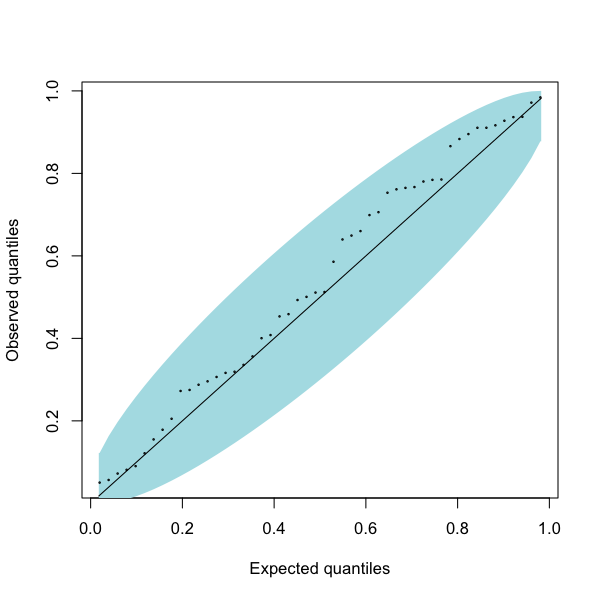

In [8]:
stats = learner.GOF_bootstrap(compensator_func=unidim_EHP_compensator )

[ 1.0290795  -0.62100483  0.99517949]


(array([ 3.,  5.,  5.,  9.,  5.,  7., 12., 15., 19., 20.]),
 array([0.0110051 , 0.10989343, 0.20878176, 0.30767008, 0.40655841,
        0.50544674, 0.60433506, 0.70322339, 0.80211172, 0.90100004,
        0.99988837]),
 <BarContainer object of 10 artists>)

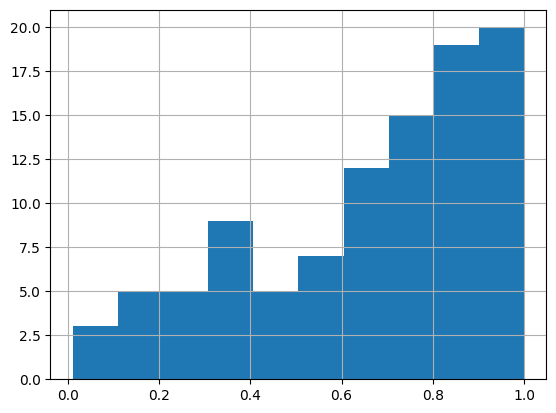

In [9]:
#### GOF PROCEDURE ####

print(learner.mean_MLE)

mu = learner.mean_MLE[0]


## pour chaque processus on effectue le changement de temps
compensator_transform = [np.array(x[1:])*mu for x in tList]  ## pour chaque répétition on transforme le processus en utilisant le compensateur


## Selection des parties à p(n) éléments
subsample = [np.random.choice(np.arange(200), size=int(200**(2/3)), replace=False) for l in range(100)]
subsample_times = [[compensator_transform[k] for k in index] for index in subsample]


### on aggrege les compensateur des parties sélectionnés 


def aggregated_process(timeslists):
    
    ### aggregate all process given
    aggList = [0.0]
    for times in timeslists:
        aggList += [aggList[-1] + i for i in times]

    ## delete the time corresponding to Lambd(Tmax) that are not actual jump time
    end_times = np.cumsum([len(times) for times in timeslists])
    max_obs_time = aggList[-1]
    
    aggList = np.array([aggList[k] for k in np.arange(end_times[-1]) if k not in end_times])
    
    return aggList,max_obs_time


    
aggregated_compensator = [aggregated_process(x)[0] for x in subsample_times]

borne_sup = 20

list_time_rescaled = [np.array(cumulated_process)[np.array(cumulated_process)<= borne_sup]/borne_sup for cumulated_process in aggregated_compensator]

pvals = [kstest(x, cdf ='uniform').pvalue for x in list_time_rescaled]

plt.hist(pvals)

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

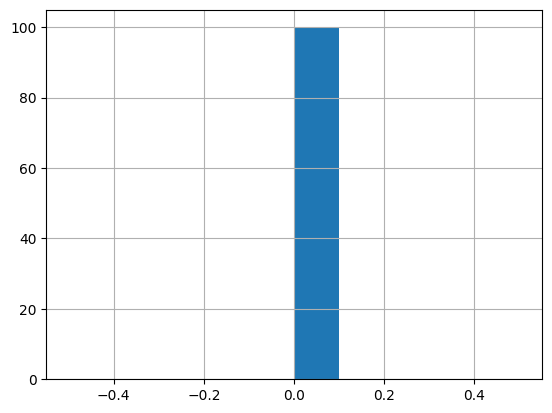

In [10]:
### on regarde les incréments des compensateurs transformé et aggrégé

increments = [x[2:]- x[1:-1] for x in aggregated_compensator]
pvals = [kstest(x, cdf ='expon').pvalue for x in increments]

plt.hist(pvals)


## Test on one coefficient

Hypothesis under test: $\mathcal{H}_0 : m = 1 \quad \text{ vs } \quad \mathcal{H}_1 : m \ne 1$.

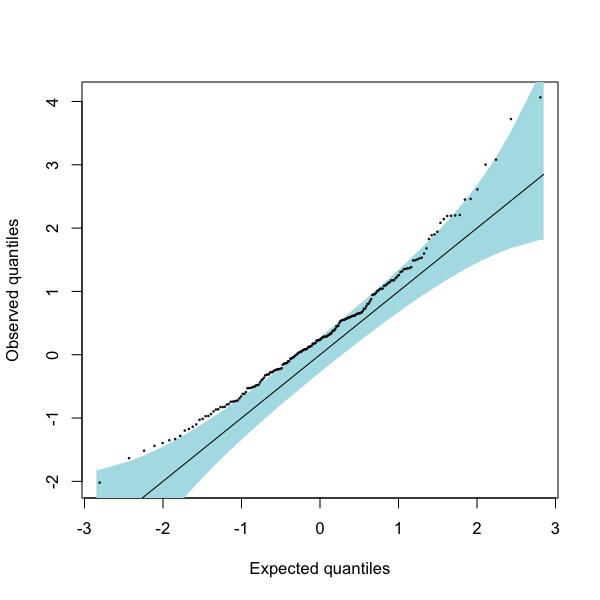

In [11]:
stat = learner.test_one_coeff(0,1, plot=True)  

Hypothesis under test: $\mathcal{H}_0 : a = 1 \quad \text{ vs } \quad \mathcal{H}_1 : a \ne 1$.

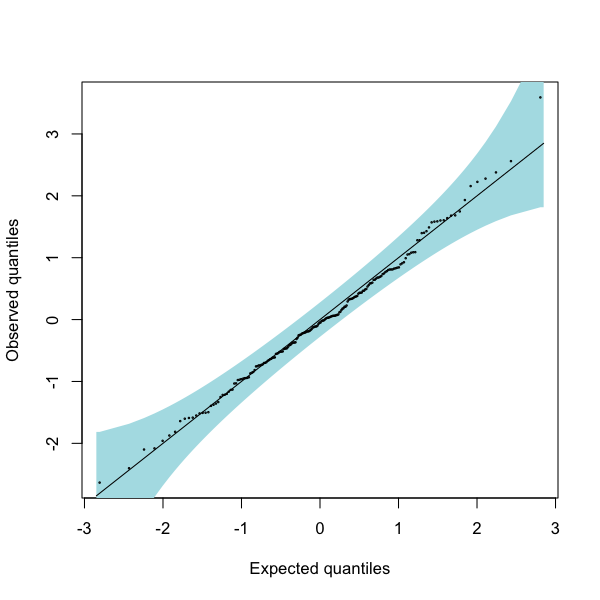

In [12]:
stat = learner.test_one_coeff(-1,1, plot = True)  

### Test of equality between coefficients 

Hypothesis under test: $\mathcal{H}_0 : a = m \quad \text{ vs } \quad \mathcal{H}_1 : a \ne m$.

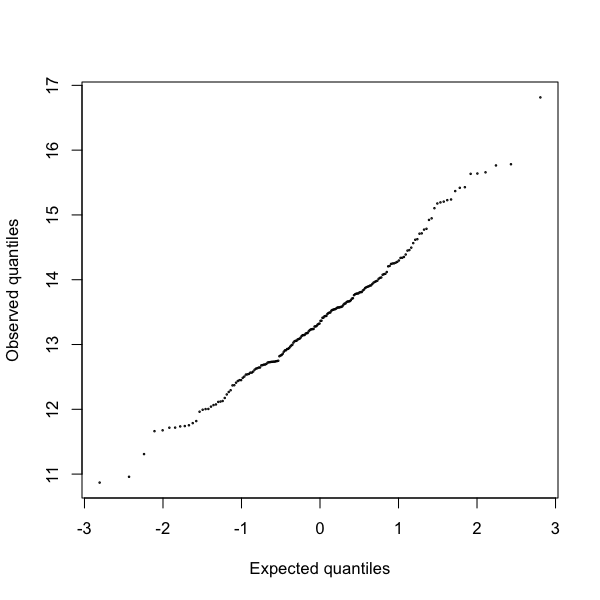

In [14]:
stat = learner.test_equality_coeff(0,1)

### Test on the model used for estimation

We present here different test on the model associated to the data, model relying on the GOF procedure. 

#### Test of the self-exiting assumption

Hypothesis under test: $\mathcal{H}_0 : \text{data are i.i.d represetation of a poisson model with an unknown parameter} $.

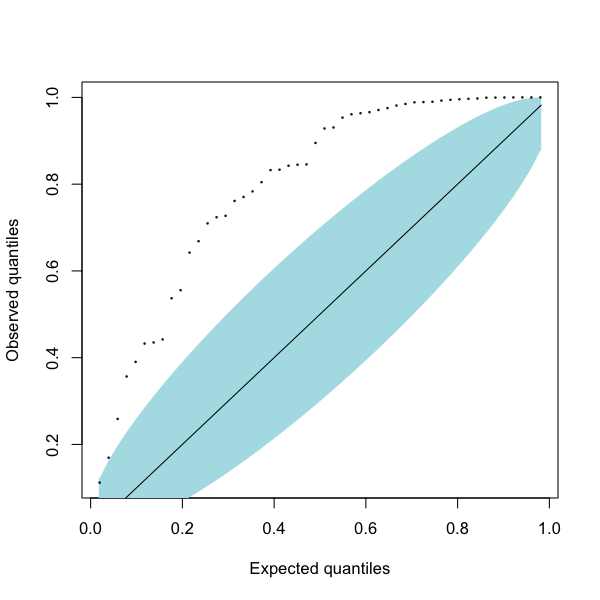

In [15]:
learner_poisson = estimator_unidim_multi_rep(loss = likelihood_Poisson)
learner_poisson.fit(tList)
stats_poisson = learner_poisson.GOF_bootstrap(compensator_func=poisson_compensator,Nb_SubSample=50, plot = True)

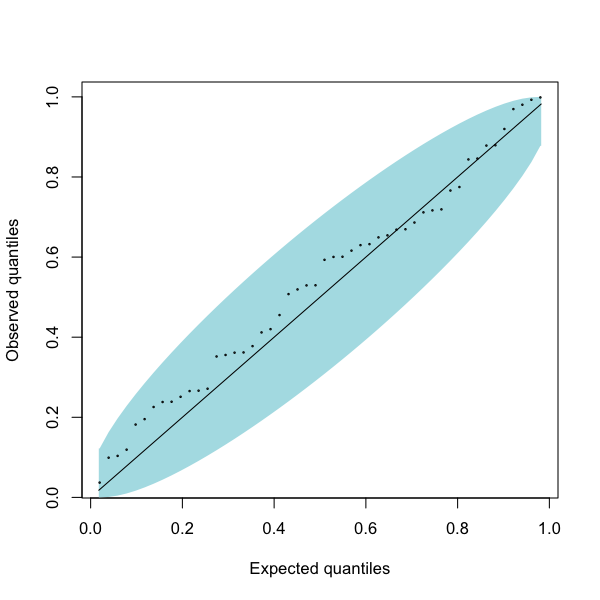

In [16]:
stats_hawkes = learner.GOF_bootstrap(compensator_func=unidim_EHP_compensator)

As a result we accept the null hypothesis assessing that the data are an iid representation of a Hawkes model.

### Test of the inhibition assumption

We test here the null hypothesis $$\mathcal{H}_0 : \text{data are i.i.d represetation of a hawkes model inhibition} $$

In [17]:
learner_hawkes_ex = estimator_unidim_multi_rep(a_bound=0)
learner_hawkes_ex.fit(tList)

array([0.62767, 0.     , 1.     ])

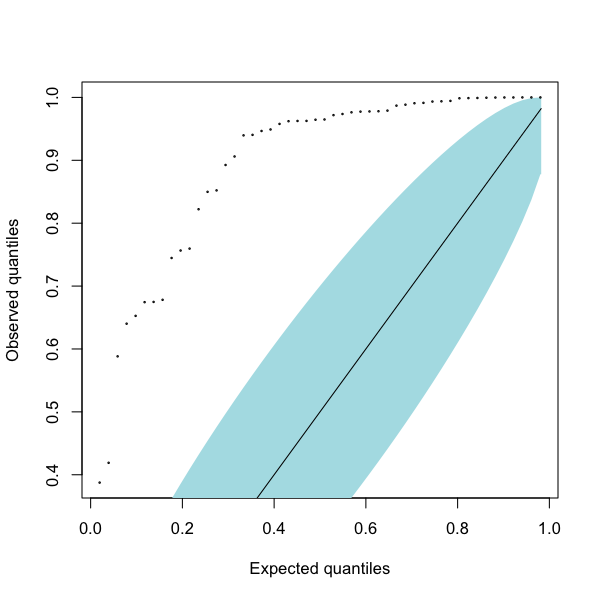

In [18]:
stats_hawkes_ex = learner_hawkes_ex.GOF_bootstrap()

### Test of the marked assumpation

We test here the null hypothesis $$\mathcal{H}_0 : \text{data are i.i.d represetation of a marked hawkes model} $$

In [19]:
import scipy.stats
from functions.hawkes_process import *
from functions.GOF import *
from functions.compensator import *
from functions.estimator_class import loglikelihood_estimator_bfgs
from functions.multivariate_exponential_process import *
import scipy
from functions.estimator_class_multi_rep import *

np.random.seed(1)


m,a,b = 1, 1.5, 2
Tmax = 700

from function_test import *


tlist, mlist = [], []

for k in range(100):
    hawkes = exp_thinning_hawkes_marked(m=m,
                                            a=a, 
                                            b=b, 
                                            F=F, 
                                            arg_F={'psi':2}, 
                                            phi=phi, 
                                            arg_phi={'gamma':1}, 
                                            max_time=Tmax)
    hawkes.simulate()
    tlist +=[[(time, mark) for time, mark in zip(hawkes.timestamps, hawkes.mark_list)]]

In [20]:
learner = estimator_unidim_multi_rep(mark = True, 
                                        f = f, 
                                        phi = phi, 
                                        name_arg_f=['psi'], 
                                        name_arg_phi=['gamma'], 
                                        initial_guess_phi=[0], 
                                        initial_guess_f=[1], 
                                        bound_f=[(1e-5, None)], 
                                        bound_phi=[(None, None)])

learner.fit(tlist)

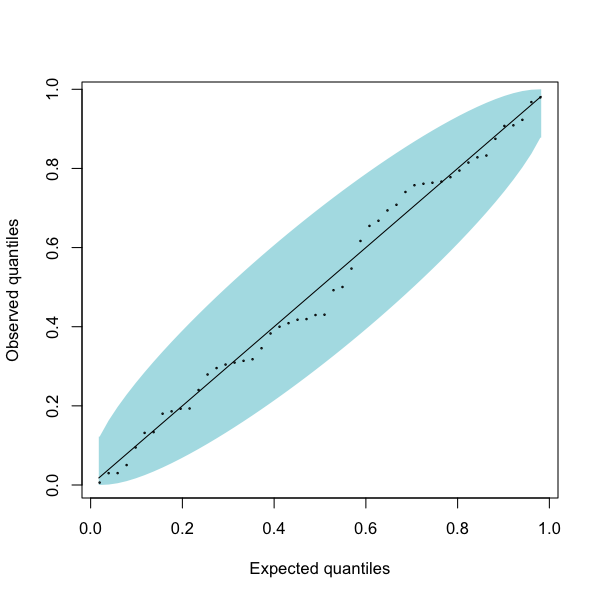

In [3]:
pvals =learner.GOF_bootstrap(compensator_func=unidim_MEHP_compensator)

# Real dataset

In [12]:
import datetime
import pandas as pd
import matplotlib.pyplot
import pandas as pd
import numpy as np

In [13]:
df = pd.read_csv('earthquake.txt')

In [31]:

scaling =60*60*24

def split_date(x):
    y = x.split('+')[0]
    if len(y)<=19:
        y = y +'.0'
    z = datetime.datetime(year=int(y[:4]), month = int(y[5:7]), day=int(y[8:10]), hour = int(y[11:13]), minute=int(y[14:16]), second= int(y[17:19]), microsecond=int(y[20:]))  
    baseline =datetime.datetime(year = int(y[:4]), month=1, day=1, hour=0, minute=0, second=0)

    return((z-baseline).total_seconds()/scaling)


In [32]:
df['date1']= df['date'].apply(split_date)
#df['magnitudo'] = df['magnitudo'].apply( lambda x : x/12)
df['year']= df['date'].apply(lambda x : int(x[:4]))


tlist_marked = []
tlist = []

for year in np.unique(df['year']):
    
    diff_year = datetime.datetime(year = year+1, month=1, day=1, hour=0, minute=0, second=0)- datetime.datetime(year = year, month=1, day=1, hour=0, minute=0, second=0)
    tlist_marked +=  [[(0,0)] + list(df.loc[df.year == year, ['date1', 'magnitudo']].itertuples(index = False, name=None)) + [(diff_year.total_seconds()/scaling,0)] ]
    tlist += [[time for time,mark in tlist_marked[-1]]]

[7.85926067e-01 5.30739550e+00 4.27009712e-01 1.27528378e+04
 7.43880309e+00]


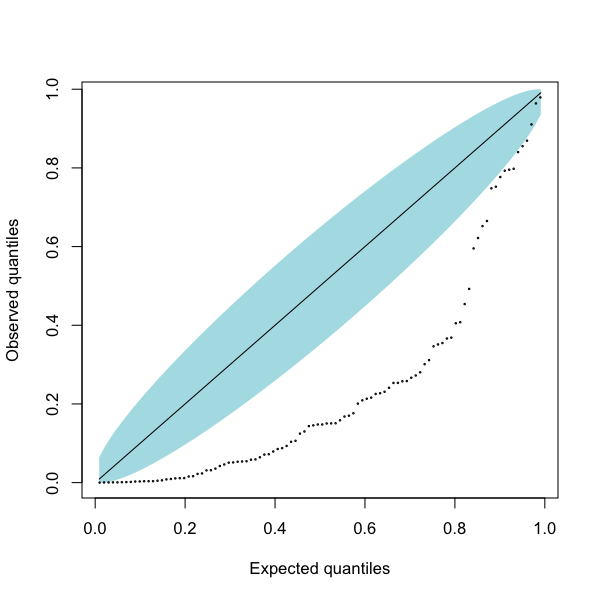

In [33]:
from function_test import f, phi1

learner_marked_hawkes = estimator_unidim_multi_rep(mark = True, 
                                                     f = f, 
                                                     phi = phi1, 
                                                     name_arg_f=['psi'], 
                                                     name_arg_phi=['gamma'], 
                                                     initial_guess_phi=[0], 
                                                     initial_guess_f=[1],
                                                     bound_f=[(0.01,None)], 
                                                     bound_phi=[(0,None)])
learner_marked_hawkes.fit(tlist_marked)
print(learner_marked_hawkes.mean_MLE)
pvals= learner_marked_hawkes.GOF_bootstrap(compensator_func=unidim_MEHP_compensator, Nb_SubSample=100 )


[0.34136511 1.42046942 8.54087617]


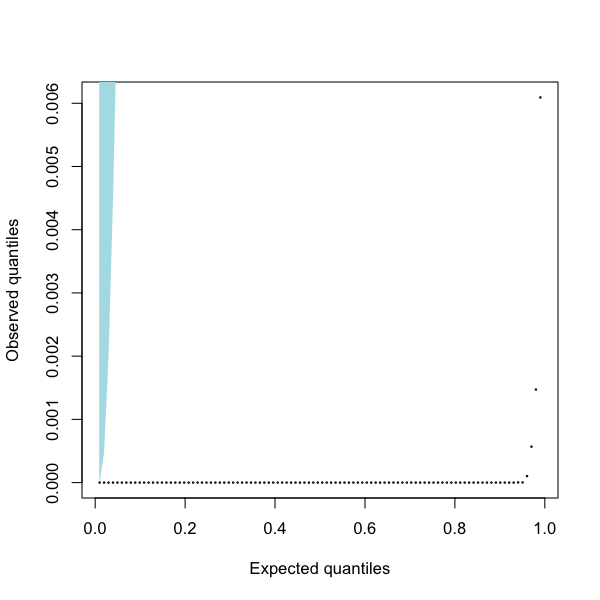

In [34]:
learner_hawkes = estimator_unidim_multi_rep()
learner_hawkes.fit(tlist)
print(learner_hawkes.mean_MLE)
pvals =learner_hawkes.GOF_bootstrap(compensator_func=unidim_EHP_compensator,Nb_SubSample=100)

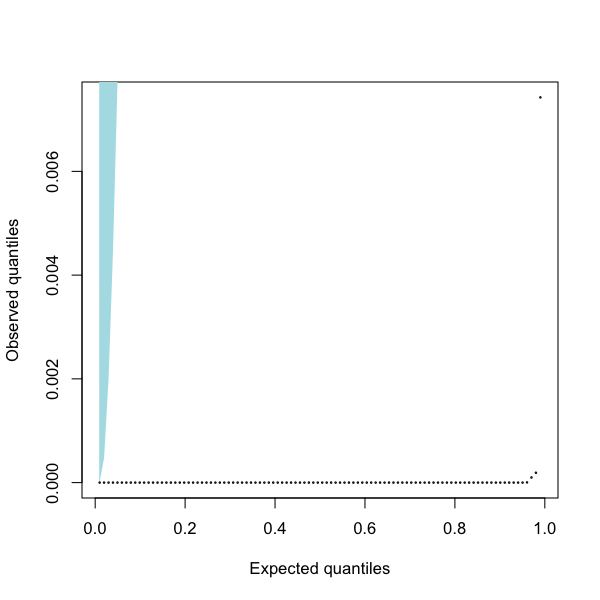

In [35]:
learner_marked_hawkes = estimator_unidim_multi_rep(loss = likelihood_Poisson)
learner_marked_hawkes.fit(tlist)
pvals =learner_marked_hawkes.GOF_bootstrap(compensator_func=poisson_compensator,Nb_SubSample=100)